In [1]:
import os

HOME = os.getcwd()
print(HOME)

LAYOUTS = '../inputs/layout_outputs'
PRODUCTS = '../inputs/products'
LAYOUTS

sample_paint = PRODUCTS+'/Paints/Orange.jpg'
sample_stone = PRODUCTS+'/Stone/ArmaniBrown.jpg'
sample_wallpaper = PRODUCTS+'/Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg'

/Users/devasenan/Documents/projects/mfs/overlaying


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance as dist

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from key_point_extractor_utils import get_rectangles

class MaskBlender:
    def __init__(self, layout_path, mat_path, seg_masks, src_path, subject_path, mode):
        self.layout_path = layout_path
        self.layout_img = cv2.imread(layout_path)
        self.mat_path = mat_path
        
        self.src_path = src_path
        
        self.subject_path = subject_path
        temp = cv2.imread(subject_path)
        self.subject_img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)

        self.mode = mode
        self.wall_masks = self.__read_imgs(seg_masks[0])
        self.floor_masks = self.__read_imgs(seg_masks[1])

        # processed_img_variables
        self.rescaled_subject = None
        self.polygons = None
        self.overlay = None
        self.mask_overlay_gray = None
        self.polygons = None
        self.implant_coordinates = None
        self.final_out = None

    def __get_mask_imgs(self, img_path):
        mask_imgs = []
        for img in os.listdir(img_path):
            if img.split('.')[-1] == 'png':
                mask_imgs.append(img_path+"/"+img)
        return mask_imgs

    def __read_imgs(self, mask_path):
        mask_imgs = self.__get_mask_imgs(mask_path) 
        # print(mask_imgs)
        masks = []
        for img in mask_imgs:
            mask = cv2.imread(img, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
            # print(bw_img.shape)
            # plt.imshow(mask)    
            masks.append(bw_img)    
        return masks

    def __sort_rectangle(self, points):
        sorted_pts = np.zeros((4, 2), dtype="int")
        s = np.sum(points, axis=1)
        sorted_pts[0] = points[np.argmin(s)]
        sorted_pts[2] = points[np.argmax(s)]

        diff = np.diff(points, axis=1)
        sorted_pts[1] = points[np.argmin(diff)]
        sorted_pts[3] = points[np.argmax(diff)]
        return sorted_pts

    def __find_intersection(self, point_set1, point_set2):
        # print(point_set1, point_set2)
        if point_set1[0][0] == point_set1[1][0] or point_set2[0][0] == point_set2[1][0]:
            pass
        else:
            point_set1[1], point_set2[0] = point_set2[0], point_set1[1]
        
        xdiff = (point_set1[0][0] - point_set1[1][0], point_set2[0][0] - point_set2[1][0])
        ydiff = (point_set1[0][1] - point_set1[1][1], point_set2[0][1] - point_set2[1][1])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
            raise Exception('lines do not intersect')

        d = (det(*point_set1), det(*point_set2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return [x, y]

    def __get_index(self, points, pt):
        for i in range(len(points)):
            p1, p2 = points[i]
            if [p1, p2] == pt:
                return i
            
    def __get_adjacent(self, points, pt):
        lpts = len(points)
        indx = self.__get_index(points, pt)
        adj1 = [i for i in points[(indx-1)%lpts]]
        adj2 = [i for i in points[(indx+1)%lpts]]
        return adj1, adj2, indx
            
    def __get_extrapt_index(self, points, pt):
        for j in range(len(points)):
            p1, p2 = points[j]
            if p2 == pt[1]:
                return j
    
    def __remove_extra_pts(self, points, extra_pts):
        new_poly = points.copy()
        for i in extra_pts:
            indx = self.__get_index(points, i)
            new_poly = np.delete(new_poly, indx, axis=0)
        return new_poly

    def __order_points(self, pts):
        # sort the points based on their x-coordinates
        xSorted = pts[np.argsort(pts[:, 0]), :]
        # grab the left-most and right-most points from the sorted
        # x-roodinate points
        leftMost = xSorted[:2, :]
        rightMost = xSorted[2:, :]
        # now, sort the left-most coordinates according to their
        # y-coordinates so we can grab the top-left and bottom-left
        # points, respectively
        leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
        (tl, bl) = leftMost
        # now that we have the top-left coordinate, use it as an
        # anchor to calculate the Euclidean distance between the
        # top-left and right-most points; by the Pythagorean
        # theorem, the point with the largest distance will be
        # our bottom-right point
        D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
        (br, tr) = rightMost[np.argsort(D)[::-1], :]
        # return the coordinates in top-left, top-right,
        # bottom-right, and bottom-left order
        return np.array([tl, tr, br, bl], dtype="int")

    def reduce_points(self, polygon):
        points = polygon.copy()
        h_layout, w_layout = self.layout_img.shape[:2]
        pts1 = [[0, 0], [w_layout, 0], [w_layout, h_layout], [0, h_layout]]
        corner_pts, extra_pts = [], []
        for pt in points:
            if pt in pts1:
                corner_pts.append(pt)
            elif pt[1] == h_layout or pt[1] == 0:
                extra_pts.append(pt)
        
        pts_without_extra = self.__remove_extra_pts(polygon, extra_pts)
        # print(pts_without_extra)

        for i in range(len(corner_pts)):
            lpts = len(pts_without_extra)
            adj1, adj2, c_indx = self.__get_adjacent(pts_without_extra, corner_pts[i])
            # print(adj1, adj2)
            e_indx = self.__get_extrapt_index(extra_pts, pts_without_extra[c_indx])
            new_pt = self.__find_intersection([adj1, corner_pts[i]], [extra_pts[e_indx], adj2])
            new_pt = np.array([new_pt], dtype=int)
            
            new_rectangle = np.delete(pts_without_extra, c_indx, axis=0)
            new_rectangle = np.append(new_rectangle, new_pt, axis=0)
            new_rectangle = self.__order_points(new_rectangle)
            # print(new_rectangle)
            return new_rectangle
        
    def rescale_subject_img(self, scale_percent):
        w_rescale, h_rescale = (self.subject_img.shape[1]*scale_percent)//100, (self.subject_img.shape[0]*scale_percent)//100
        h, w = self.subject_img.shape[:-1]
        rescaled_subject_image = cv2.resize(self.subject_img, [w_rescale, h_rescale], interpolation=cv2.INTER_AREA)
        self.rescaled_subject = rescaled_subject_image
        plt.imshow(rescaled_subject_image)
        
    def __calculate_w_h(self, polygon):
        n_pts = len(polygon)
        edge_2 = polygon[1:-1]
        edge_3 = polygon[2:]
        all_distances = {}
        
        for edge in [edge_2, edge_3]:
            p1 = edge[0]
            p2 = edge[1]
            # print(p1, p2)
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            all_distances[dist] = [p1, p2]
            # print(all_distances)
        return [*all_distances.keys()]
    
    def __replicate_subject(self, polygon):
        h_subject, w_subject = self.rescaled_subject.shape[:2]

        h_base, _ = self.layout_img.shape[:2]
        _, w_base = self.__calculate_w_h(polygon)
        
        num_of_tiles_per_row = round(h_base / h_subject)-1
        num_of_tiles_per_col = round(w_base / w_subject)
        # print(num_of_tiles_per_row, num_of_tiles_per_col)

        dup_cols = self.rescaled_subject.copy()
        ## duplicate the subject image
        for i in range(num_of_tiles_per_col):
            dup_cols = np.concatenate([dup_cols, self.rescaled_subject], axis = 1)
        dup_rows = dup_cols.copy()
        for i in range(num_of_tiles_per_row):
            dup_rows = np.concatenate([dup_rows, dup_cols], axis=0)
        
        duplicated_tiles = dup_rows.copy()
        # plt.imshow(duplicated_tiles)
        return duplicated_tiles
    
    def perspective_warp(self, polygon):
        if len(polygon) > 4:
            sorted_pts = self.reduce_points(polygon)
        else:
            sorted_pts = self.__order_points(np.array(polygon))

        # print(polygon)
        duplicated_sub = self.__replicate_subject(sorted_pts)
        # plt.imshow(duplicated_sub)
        h_base, w_base, c_base = self.layout_img.shape
        h_subject, w_subject = duplicated_sub.shape[:2]
        pts1 = np.float32([[0, 0], [w_subject, 0], [w_subject, h_subject], [0, h_subject]])
        pts2 = np.float32(sorted_pts)
        # print(pts2, sorted_pts)

        transformation_matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # print(transformation_matrix)
        warped_img = cv2.warpPerspective(duplicated_sub, transformation_matrix, (w_base, h_base))
        # plt.imshow(warped_img)
        return warped_img
    
    def __combine_warps(self, polygons):
        combined_warp = np.zeros(self.layout_img.shape, dtype=np.uint8)
        for polygon in polygons:
            warp = self.perspective_warp(polygon)
            # plt.imshow(warp)
            combined_warp = cv2.bitwise_or(combined_warp, warp)
        # plt.imshow(combined_warp)
        self.overlay = combined_warp
    
    def __combine_masks(self):
        combine_masks = np.zeros(self.layout_img.shape, dtype=np.uint8)
        masks = self.wall_masks if self.mode==0 else self.floor_masks
        
        for mask in masks:
            combine_masks = cv2.bitwise_or(combine_masks, mask)
        self.mask_overlay_gray = cv2.cvtColor(combine_masks, cv2.COLOR_RGB2GRAY)
        # self.mask_overlay = cv2.bitwise_and(combine_masks, self.wall_overlay)
        
        # plt.imshow(self.mask_overlay_gray, cmap='gray')
        self.implant_coordinates = np.where(self.mask_overlay_gray > 0)

    def implant_overlay(self):
        rectangles = get_rectangles(self.layout_path, self.mat_path)
        if self.mode == 0:
            self.polygons = np.array(rectangles[0], dtype=int)
        elif self.mode == 1:
            self.polygons = np.array(rectangles[1], dtype=int)

        print(self.polygons)
        self.__combine_warps(self.polygons)
        self.__combine_masks()

        white_coordinates = self.implant_coordinates
    
        fg, ax = plt.subplots(1, 2, figsize=(14, 7))
        ax1 = ax[0]
        ax2 = ax[1]
        src_img = cv2.imread(self.src_path)
        src_img = cv2.GaussianBlur(src_img,(5,5),0)
        ax1.imshow(src_img)

        final_img = src_img.copy()
        final_img[white_coordinates] = self.overlay[white_coordinates]
        self.final_out = final_img
        
        ax2.imshow(final_img)
        return self.final_out

not_working - 3, img2
not_proper - img6, img8, img9, test3, test4
working = img1, img3, kitchen, test, test1

In [ ]:
get_rectangles(layout_input, layout_mat)

[[[   0 -196]
  [ 860   52]
  [ 860  701]
  [   0  975]]

 [[ 860   52]
  [1599 -150]
  [1599  870]
  [ 860  701]]]


'0.657s'

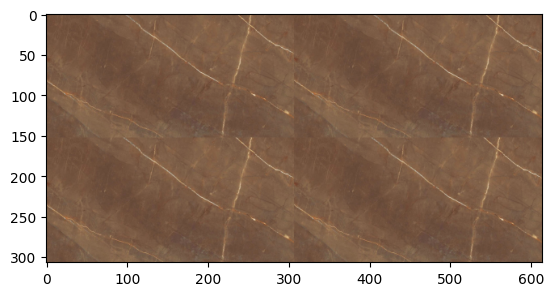

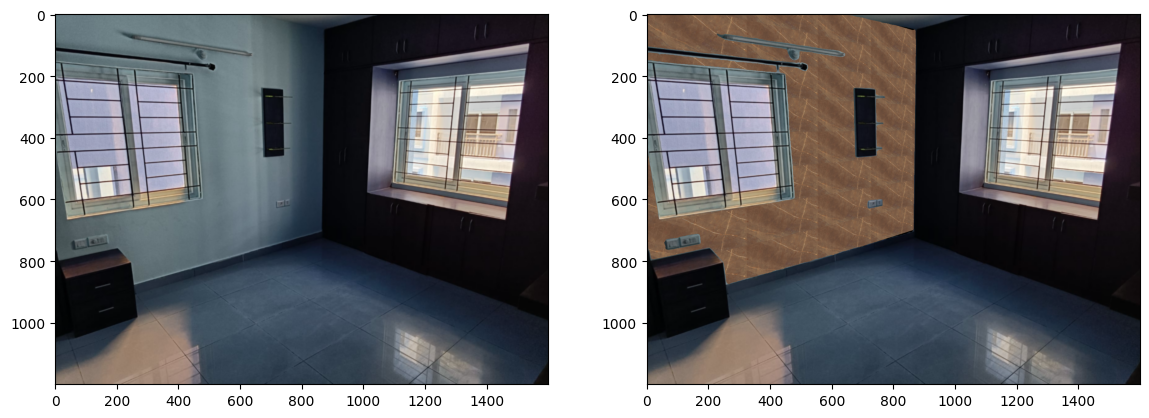

In [5]:
in_name = 'img1'
subject_rescale_percent = 15

layout_input = LAYOUTS+"/{}.jpeg".format(in_name)
layout_mat = LAYOUTS+"/{}.txt".format(in_name)
wall_mask = '../inputs/wall_masks/{}'.format(in_name)
floor_mask = '../inputs/floor_masks/{}'.format(in_name)
src_img = '../inputs/src_imgs/{}.jpeg'.format(in_name)

blender = MaskBlender(
        layout_input,
        layout_mat,
        [wall_mask, floor_mask],
        src_img,
        sample_stone,
        # 0 for walls, 1 for floors
        mode=0
        )

st = time.time()
blender.rescale_subject_img(subject_rescale_percent)
final_out = blender.implant_overlay()
et = time.time()
cv2.imwrite("../outs/{}.jpg".format(in_name), cv2.cvtColor(blender.final_out, cv2.COLOR_BGR2RGB))
"{:.3f}s".format(et-st)

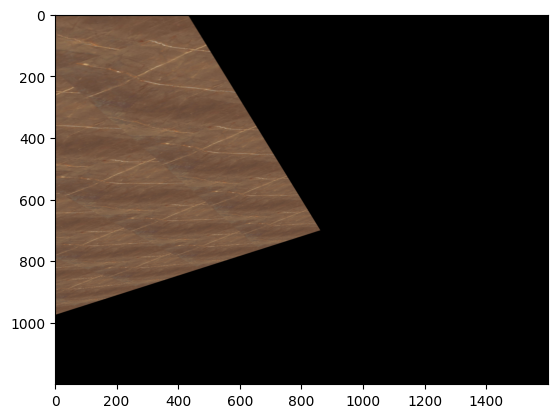

In [14]:
plt.imshow(blender.overlay)